# Image Captioning with Visual Attention 

## Learning Objectives
1. Learn how to create an image captioning model
2. Learn how to train and predict a text generation model.

Image captioning models take an image as input, and output text. Ideally, we want the output of the model to accurately describe the events/things in the image, similar to a caption a human might provide. <br>
For example, given an image like the example below, the model is expected to generate a caption such as *"some people are playing baseball."*.

![https://en.wikipedia.org/wiki/Batting_%28baseball%29#/media/File:Marcus_Thames_Tigers_2007.jpg](./sample_images/baseball.jpeg)


In order to generate text, we will build an encoder-decoder model, where the encoder output embedding of an input image, and the decoder output text from the image embedding<br>

I this notebook, we will use the model architecture similar to [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044), and build Attention-based image captioning model.

This notebook is an end-to-end example. The training dataset is the COCO large-scale object detection, segmentation, and captioning dataset.


## Preparation

In [1]:
import time
from textwrap import wrap

import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

print(tf.version.VERSION)

device_name = tf.test.gpu_device_name()
if device_name != "/device:GPU:0":
    raise SystemError("GPU device not found")
print(f"Found GPU at: {device_name}")

2.8.2
Found GPU at: /device:GPU:0


2022-06-15 21:18:15.445487: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-15 21:18:16.105032: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-15 21:18:16.117097: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-15 21:18:16.117811: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [2]:
!rm -rf /tmp/*tfds*

## Read and prepare dataset

We will use the TensorFlow datasets capability to read the [COCO captions](https://www.tensorflow.org/datasets/catalog/coco_captions) dataset.
This version contains images, bounding boxes, labels, and captions from COCO 2014, split into the subsets defined by Karpathy and Li (2015) and takes
care of some data quality issues with the original dataset (for example, some
of the images in the original dataset did not have captions)

First, let's define some constants.<br>
In this lab, we will use a pretrained [InceptionResNetV2](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_resnet_v2/InceptionResNetV2) model as a feature extractor, so some constants are comming from the InceptionResNetV2 model definition.

So if you want to use other type of base model, please make sure to change these constans as well.

In [3]:
# Change these to control the accuracy/speed
VOCAB_SIZE = 5000  # use fewer words to speed up convergence
ATTENTION_DIM = (
    512  # size of dense layer in Attention; larger more fine-grained
)
WORD_EMBEDDING_DIM = 128

# InceptionResNetV2 takes (224, 224, 3) image as inputs
# and return features in (8, 8, 1536) shape
FEATURE_EXTRACTOR = tf.keras.applications.inception_resnet_v2.InceptionResNetV2
IMG_HEIGHT = 299
IMG_WIDTH = 299
IMG_CHANNELS = 3
FEATURES_SHAPE = (8, 8, 1536)

### Filter and Preprocess
Here we preprocess the dataset. The function below:
- resize image to (`IMG_HEIGHT`, `IMG_WIDTH`) shape
- rescale pixel values to [0,1]
- return image(`image_tensor`) and captions(`captions`) dictionary.

**Note**: This dataset is too large to store in an ephemeral location. Therefore, It is stored in a public GCS bucket. 
If you access it from a Notebook outside the US, it will be (a) slow and (b) subject to a network charge.

In [4]:
GCS_DIR = "gs://asl-public/data/tensorflow_datasets/"


def get_image_label(example):
    caption = example["captions"]["text"][0]  # only the first caption per image
    img = example["image"]
    img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = img / 255
    return {"image_tensor": img, "caption": caption}


trainds = tfds.load("coco_captions", split="train", data_dir=GCS_DIR)

trainds = trainds.map(get_image_label, num_parallel_calls=tf.data.AUTOTUNE)
trainds = trainds.prefetch(buffer_size=tf.data.AUTOTUNE)

2022-06-17 09:45:41.775119: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-17 09:45:41.775955: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-17 09:45:41.776649: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-17 09:45:41.777816: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-17 09:45:41.778514: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

### Visualize 
Let's take a look at images and sample captions in the dataset.

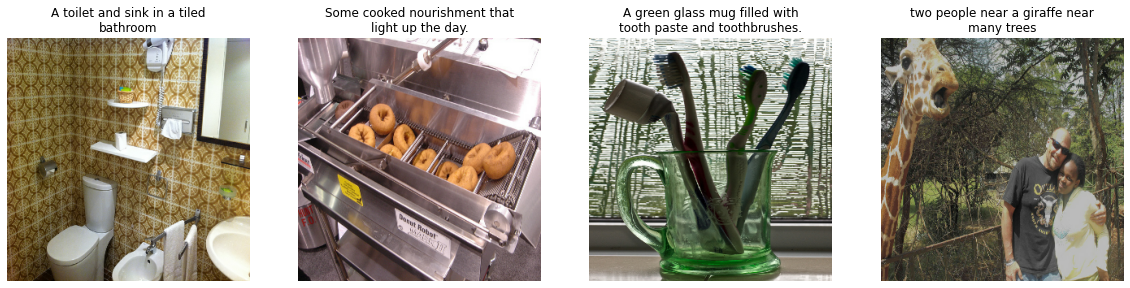

In [5]:
f, ax = plt.subplots(1, 4, figsize=(20, 5))
for idx, data in enumerate(trainds.take(4)):
    ax[idx].imshow(data["image_tensor"].numpy())
    # ax[idx].set_xlabel('image_id={}'.format(data['image_id'].numpy()))
    caption = "\n".join(wrap(data["caption"].numpy().decode("utf-8"), 30))
    ax[idx].set_title(caption)
    ax[idx].axis("off")

## Text Preprocessing

We add special tokens to represent the starts (`<start>`) and the ends (`<end>`) of sentences.

Then create a full list of the captions for further preprocessing.

**Note**: This process takes around 5 minutes.

In [5]:
# Stop words for stability
MAX_CAPTION_LEN = 1


def preprocess_caption(c):
    global MAX_CAPTION_LEN
    caption = "<start> {} <end>".format(c.decode("utf-8"))
    words = caption.lower().split()
    MAX_CAPTION_LEN = max(MAX_CAPTION_LEN, len(words))
    return " ".join(words)


train_captions = []

for data in trainds:
    str_caption = preprocess_caption(data["caption"].numpy())
    train_captions.append(str_caption)

## Preprocess and tokenize the captions

You will transform the text captions into integer sequences using the [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) layer, with the following steps:

* Use [adapt](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization#adapt) to iterate over all captions, split the captions into words, and compute a vocabulary of the top `VOCAB_SIZE` (like 5000) words (to save memory).
* Tokenize all captions by mapping each word to its index in the vocabulary. All output sequences will be padded to length `MAX_CAPTION_LEN` that was computed above.
* Create word-to-index and index-to-word mappings to display results.

In [7]:
# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
    return tf.strings.regex_replace(
        inputs, r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", ""
    )


# Choose the most frequent words from the vocabulary & remove punctuation etc.
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize=standardize,
    output_sequence_length=MAX_CAPTION_LEN,
)
tokenizer.adapt(train_captions)


Let's try to tokenize a sample text 

In [8]:
tokenizer(["<start> This is a sentence <end>"])

<tf.Tensor: shape=(1, 51), dtype=int64, numpy=
array([[ 3,  1, 11,  2,  1,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0]])>

In [9]:
print(train_captions[:5])

['<start> a toilet and sink in a tiled bathroom <end>', '<start> some cooked nourishment that light up the day. <end>', '<start> a green glass mug filled with tooth paste and toothbrushes. <end>', '<start> two people near a giraffe near many trees <end>', '<start> the bench next to the gate is covered in snow. <end>']


In [10]:
print(tokenizer(train_captions[:5]))

tf.Tensor(
[[   3    2   98   10  148    8    2  590   61    4    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0]
 [   3   33  823    1   26  192   40    7  349    4    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0]
 [   3    2   50  176 1341   63    9  986 3934   10 4155    4    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0]
 [   3   17   20   41    2  101   41  136  215    4    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0  

And you can convert ids to original text.

In [11]:
for wordid in tokenizer([train_captions[0]])[0]:
    print(tokenizer.get_vocabulary()[wordid], end=" ")

<start> a toilet and sink in a tiled bathroom <end>                                          

Also, we can create Word <-> Index converters using `StringLookup` layer.

In [12]:
# Lookup table: Word -> Index
word_to_index = tf.keras.layers.StringLookup(
    mask_token="", vocabulary=tokenizer.get_vocabulary()
)

# Lookup table: Index -> Word
index_to_word = tf.keras.layers.StringLookup(
    mask_token="", vocabulary=tokenizer.get_vocabulary(), invert=True
)

### Create a tf.data dataset for training
Now Let's apply the adapted tokenization to all the examples and create tf.data Dataset for training.

Here we concatenate `trainds` and `train_captions` in a single dataset object so that we can use it in training.<br>
Also note that here we shuffle data, and create batches of examples.

In [13]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000


def create_ds_fn(data, str_caption):
    img_tensor = data["image_tensor"]
    caption = tokenizer(str_caption)
    return img_tensor, caption


train_captions_ds = tf.data.Dataset.from_tensor_slices(train_captions)
batched_ds = tf.data.Dataset.zip((trainds, train_captions_ds))
batched_ds = (
    batched_ds.map(create_ds_fn)
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

for img, caption in batched_ds.take(2):
    print(f"Image shape: {img.shape}")
    print(f"Caption shape: {caption.shape}")
    print(caption[0])

Image shape: (32, 299, 299, 3)
Caption shape: (32, 51)
tf.Tensor(
[  3   2 160   5 276 222   6   2 199   4   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0], shape=(51,), dtype=int64)
Image shape: (32, 299, 299, 3)
Caption shape: (32, 51)
tf.Tensor(
[  3   2 121 179  21   2 581  21 606   4   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0], shape=(51,), dtype=int64)


## Model
Now let's design an image captiong model.<br>
It consists of an image encoder, followed by a caption decoder.

The model architecture is inspired by the [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf) paper.

### Image Encoder
The image encoder model is very simple. It extracts features through a pretrained model and passes them to a fully connected layer.

1. In this example, you extract the features from the lower convolutional layer of InceptionResNetV2 giving us a vector of (Batch Size, 8, 8, 1536).
1. You reshape the vector to (Batch Size, 64, 1536)
1. You squash that to a length of `ATTENTION_DIM` with a Dense Layer and return (Batch Size, 64, ATTENTION_DIM)
1. Later the Attention layer attends over the image to predict the next word.


In [16]:
class ImageEncoder(tf.keras.Model):
    def __init__(self, attention_dim):
        super().__init__()
        feature_extractor = FEATURE_EXTRACTOR(
            include_top=False, weights="imagenet"
        )
        self.model = tf.keras.Model(
            feature_extractor.input, feature_extractor.layers[-1].output
        )
        self.model.trainable = False
        self.fc = tf.keras.layers.Dense(attention_dim)

    def call(self, x):
        x = self.model(x)
        x = tf.reshape(x, (x.shape[0], -1, x.shape[3]))
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [15]:
encoder = ImageEncoder(ATTENTION_DIM)

### Decoder Part
The caption decoder incorporates an attention mechanism that focuses on different parts of the input image.


#### The attention head

The decoder uses attention to selectively focus on parts of the input sequence.
The attention takes a sequence of vectors as input for each example and returns an "attention" vector for each example. This attention layer is similar to a `layers.GlobalAveragePoling1D` but the attention layer performs a _weighted_ average.

Let's look at how this works:

<img src="https://user-images.githubusercontent.com/6895245/173408554-d4b6387b-248b-421e-8911-550d0561d001.png" alt="attention equation 1" width="800">

<img src="https://user-images.githubusercontent.com/6895245/173408648-38c6b582-a68b-4697-982a-1d885b83dd0b.png" alt="attention equation 2" width="800">

Where:

* $s$ is the encoder index.
* $t$ is the decoder index.
* $\alpha_{ts}$ is the attention weights.
* $h_s$ is the sequence of encoder outputs being attended to (the attention "key" and "value" in transformer terminology).
* $h_t$ is the the decoder state attending to the sequence (the attention "query" in transformer terminology).
* $c_t$ is the resulting context vector.
* $a_t$ is the final output combining the "context" and "query".

The equations:

1. Calculates the attention weights, $\alpha_{ts}$, as a softmax across the encoder's output sequence.
2. Calculates the context vector as the weighted sum of the encoder outputs.

Last is the $score$ function. Its job is to calculate a scalar logit-score for each key-query pair. There are two common approaches:

<img src="https://user-images.githubusercontent.com/6895245/173408773-3781cacc-de00-49c6-9909-f6cd65a0501b.png" alt="attention equation 4" width="800">

This notebook implement [Bahdanau's additive attention](https://arxiv.org/pdf/1409.0473.pdf) with pre-defined `layers.AdditiveAttention`.

#### Caption Decoder

The decoder's job is to generate predictions for the next output token.

1. The decoder receives the complete encoder output.
1. Bahdanau-style attention attends over the encoder's output feature by using GRU hidden state as a query.
1. It uses a GRU to keep track of what it has generated.
1. It generates logit predictions for the next token based on the GRU output.


In [17]:
class CaptionDecoder(tf.keras.Model):
    def __init__(self, attention_dim, word_embed_dim, vocab_size):
        super().__init__()
        self.attention_dim = attention_dim

        self.embedding = tf.keras.layers.Embedding(vocab_size, word_embed_dim)

        self.gru = tf.keras.layers.GRU(
            self.attention_dim,
            return_sequences=True,
            return_state=True,
            recurrent_initializer="glorot_uniform",
        )
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = tf.keras.layers.AdditiveAttention()

    def call(self, x, features, hidden):
        # (batch_size, attention_dim) => (batch_size, 1, attention_dim)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # attention from GRU hidden state to image feature.
        # context_vector shape == (batch_size, 1, attention_dim)
        # attention_weights shape == (batch_size, 1, 64)
        context_vector, attention_weights = self.attention(
            [hidden_with_time_axis, features], return_attention_scores=True
        )

        # Embed x, which is the word index in the current step:
        # (batch_size, 1) -> (batch_size, 1, word_embed_dim)
        x = self.embedding(x)
        #  (batch_size, 1, attention_dim + embedding_dim)
        x = tf.concat([context_vector, x], axis=-1)

        # passing the concatenated vector to the GRU
        # output shape == (batch_size, 1, max_length)
        # state shape == (batch_size, attention_dim)
        output, state = self.gru(x)

        # x shape == (batch_size, max_length)
        x = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab_size)
        x = self.fc(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.attention_dim))

In [18]:
decoder = CaptionDecoder(ATTENTION_DIM, WORD_EMBEDDING_DIM, VOCAB_SIZE)

### Loss Function
The loss function is a simple cross-entropy, but we need to remove padding (`0`) when calculating it.

In [19]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="none"
)


def loss_function(real, pred):
    # returns 1 to word index and 0 to padding (e.g. [1,1,1,1,1,0,0,0,0,...,0])
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask  # Remove padding

    return tf.reduce_mean(loss_)

## Training loop

* You extract the features from images through the encoder.
* The encoder output, hidden state(initialized to 0), and the decoder input (which is the start token) is passed to the decoder.
* The decoder returns the predictions and the decoder's hidden state.
* The decoder's hidden state is then passed back into the model, and the predictions will be used to calculate the loss.
* Use teacher forcing to decide the next input to the decoder. (Teacher forcing is the technique where the target word is passed as the next input to the decoder.)
* The final step is to calculate the gradients and apply it to the optimizer and backpropagate.


In [20]:
loss_plot = []

# Called for each step of training
@tf.function()
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    # initialize the batch of predictions with [[3],[3], ...] i.e. with start tokens
    dec_input = tf.expand_dims([word_to_index("<start>")] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = loss / int(target.shape[1])

    trainable_variables = (
        encoder.trainable_variables + decoder.trainable_variables
    )
    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

Here we add checkpoint to save model state in case the training is crashed for some reason.<br>
This is important especially when we run training for a long time.

In [21]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(
    encoder=encoder, decoder=decoder, optimizer=optimizer
)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

Now we iterate the `train_step` that we defined.

**Note** The the training takes around 20 minutes with 1 GPU. Also, please ignore GPU error messages.

In [22]:
EPOCHS = 1  # train longer for greater accuracy

for epoch in range(EPOCHS):
    start = time.time()
    total_loss = 0
    num_steps = 0

    for batch, (img_tensor, target) in enumerate(batched_ds):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        num_steps += 1

        if batch % 100 == 0:
            print(
                "Epoch {} Batch {} Loss {:.4f}".format(
                    epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])
                )
            )
        loss_plot.append(batch_loss.numpy() / int(target.shape[1]))

    current_loss = total_loss / num_steps

    ckpt_manager.save()

    print(
        "Epoch {} Loss {:.6f} Time taken {:.1f} sec".format(
            epoch + 1, current_loss, time.time() - start
        )
    )

2022-07-15 14:34:41.004961: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14467989504 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2022-07-15 14:34:41.005708: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores:

Epoch 1 Batch 0 Loss 1.8455
Epoch 1 Batch 100 Loss 1.2451
Epoch 1 Batch 200 Loss 1.1522
Epoch 1 Batch 300 Loss 1.1579
Epoch 1 Batch 400 Loss 1.2791
Epoch 1 Batch 500 Loss 1.2759
Epoch 1 Batch 600 Loss 1.2992
Epoch 1 Batch 700 Loss 1.1890
Epoch 1 Batch 800 Loss 1.1760
Epoch 1 Batch 900 Loss 1.0696
Epoch 1 Batch 1000 Loss 0.9754
Epoch 1 Batch 1100 Loss 0.9542
Epoch 1 Batch 1200 Loss 0.8685
Epoch 1 Batch 1300 Loss 0.8134
Epoch 1 Batch 1400 Loss 0.7604
Epoch 1 Batch 1500 Loss 0.7570
Epoch 1 Batch 1600 Loss 0.8223
Epoch 1 Batch 1700 Loss 0.7883
Epoch 1 Batch 1800 Loss 0.6732
Epoch 1 Batch 1900 Loss 0.7186
Epoch 1 Batch 2000 Loss 0.7793
Epoch 1 Batch 2100 Loss 0.6752
Epoch 1 Batch 2200 Loss 0.7259
Epoch 1 Batch 2300 Loss 0.6359
Epoch 1 Batch 2400 Loss 0.6540
Epoch 1 Batch 2500 Loss 0.7019
Epoch 1 Loss 0.936452 Time taken 1177.0 sec


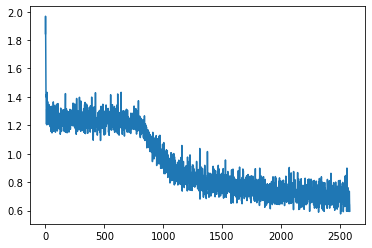

In [24]:
plt.plot(loss_plot);

## Caption!

* The `predict_caption` function is similar to the training loop, except you don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Select Top-K words from logits, and chose the word probabilisticly so that we avoid computing softmax over VOCAB_SIZE-sized vector.
* Stop predicting when the model predicts the end token.
* Optionally, during the prediction, you can control the caption by adding masks.

In [24]:
MINIMUM_SENTENCE_LENGTH = 5

## Probabilistic prediction using the trained model
def predict_caption(filename):
    attention_plot = np.zeros(
        (MAX_CAPTION_LEN, FEATURES_SHAPE[0] * FEATURES_SHAPE[1])
    )
    hidden = decoder.reset_state(batch_size=1)

    img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
    img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = img / 255

    features = encoder(tf.expand_dims(img, axis=0))
    dec_input = tf.expand_dims([word_to_index("<start>")], 1)
    result = []
    previous_word_ids = []
    for i in range(MAX_CAPTION_LEN):
        predictions, hidden, attention_weights = decoder(
            dec_input, features, hidden
        )
        attention_plot[i] = tf.reshape(attention_weights, (-1,)).numpy()

        # mask out <start> <end> and unkonw words, since we don't want them so far
        masked_predictions = predictions[0]
        mask = [1.0] * (masked_predictions.shape[0])
        mask[word_to_index("<start>").numpy()] = 0
        mask[word_to_index("<end>").numpy()] = 0
        mask[word_to_index("___UNKNOWN___").numpy()] = 0

        # <end> is okay after some time
        if i > MINIMUM_SENTENCE_LENGTH - 1:
            mask[word_to_index("<end>").numpy()] = 1
        # avoid repeating words
        # for p in previous_word_ids:
        #     mask[p] = 0
        mask = tf.convert_to_tensor(mask)
        masked_predictions *= mask

        # draws from log distribution given by predictions
        top_probs, top_idxs = tf.math.top_k(
            input=masked_predictions, k=10, sorted=False
        )
        chosen_id = tf.random.categorical([top_probs], 1)[0].numpy()
        predicted_id = top_idxs.numpy()[chosen_id][0]

        result.append(tokenizer.get_vocabulary()[predicted_id])
        previous_word_ids.append(predicted_id)

        if index_to_word(predicted_id).numpy() == b"<end>":
            return img, result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 1)

    attention_plot = attention_plot[: len(result), :]
    return img, result, attention_plot

a baseball player is standing with a game.
a baseball player holding the field.
a baseball player standing in front of a baseball player with a baseball bat.
a man is on a bat and umpire in the ball.
a man on an baseball.


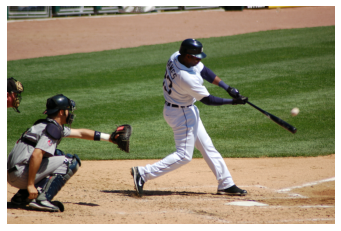

In [29]:
filename = "./sample_images/baseball.jpeg"  # you can also try surf.jpeg

img, result, attention_plot = predict_caption(filename)

for i in range(5):
    image, caption, attention_plot = predict_caption(filename)
    print(" ".join(caption[:-1]))
img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
plt.imshow(img)
plt.axis("off");

How does it look?<br>
It seems the model has managed to capture the key aspects of the image: people, baseball, and a ball, although it is not grammatically precise.

### Optional Task:
Upload your own image and generate captions with it.<br>
Also, you can try to train longer to achieve better captions.

## Summary
We learned how to build an image captioning model by creating an image encoder and a text decoder.

Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.